In [1]:
# pip install pandas

In [2]:
# pip install numpy  scikit-learn matplotlib

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [2]:
csv_file = "corrected_csv_file.csv"
data = pd.read_csv(csv_file)
data.head(10)

,Sample No,Image Name,SPAD Value
0,1,IMG_3547.JPG,89.9
1,1,IMG_3548.JPG,89.9
2,1,IMG_3549.JPG,89.9
3,1,IMG_3550.JPG,89.9
4,1,IMG_3551.JPG,89.9
5,1,IMG_3552.JPG,89.9
6,1,IMG_3556.JPG,89.9
7,2,IMG_3557.JPG,98.7
8,2,IMG_3558.JPG,98.7
9,2,IMG_3559.JPG,98.7


In [3]:
image_folder = "capscum_org3/"
weights_path = "efficientnetb0_notop.h5"

In [4]:
def load_data(dataframe, image_folder):
    images = []
    labels = []
    for _, row in dataframe.iterrows():
        img_path = image_folder + row["Image Name"]
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        images.append(image)
        labels.append(row["SPAD Value"])
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_data(data, image_folder)

In [6]:
images = images / 255.0

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


In [10]:
print(len(y_test))
print(len(y_train))
print(len(y_val))

35
99
43


In [11]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights=None)
base_model.load_weights(weights_path)
base_model.trainable = False

In [12]:
model = Sequential([
        base_model,
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [14]:
history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Reduced number of epochs to avoid overfitting with small dataset
        verbose=1  # Suppress training output for clarity
    )

Epoch 1/50
4/4 [==============================] - 26s 2s/step - loss: 3944.5164 - mae: 57.8569 - mse: 3944.5166 - val_loss: 3849.5193 - val_mae: 57.4522 - val_mse: 3849.5195
Epoch 2/50
4/4 [==============================] - 1s 153ms/step - loss: 2832.3276 - mae: 47.1688 - mse: 2832.3279 - val_loss: 2243.5278 - val_mae: 42.2850 - val_mse: 2243.5278
Epoch 3/50
4/4 [==============================] - 1s 144ms/step - loss: 1505.0438 - mae: 33.0480 - mse: 1505.0441 - val_loss: 913.0997 - val_mae: 25.4249 - val_mse: 913.0998
Epoch 4/50
4/4 [==============================] - 1s 154ms/step - loss: 963.1998 - mae: 25.3403 - mse: 963.1998 - val_loss: 830.0074 - val_mae: 23.1346 - val_mse: 830.0074
Epoch 5/50
4/4 [==============================] - 1s 136ms/step - loss: 1190.1383 - mae: 27.6120 - mse: 1190.1382 - val_loss: 729.5874 - val_mae: 21.9737 - val_mse: 729.5874
Epoch 6/50
4/4 [==============================] - 1s 138ms/step - loss: 936.9842 - mae: 24.9431 - mse: 936.9841 - val_loss: 802.37

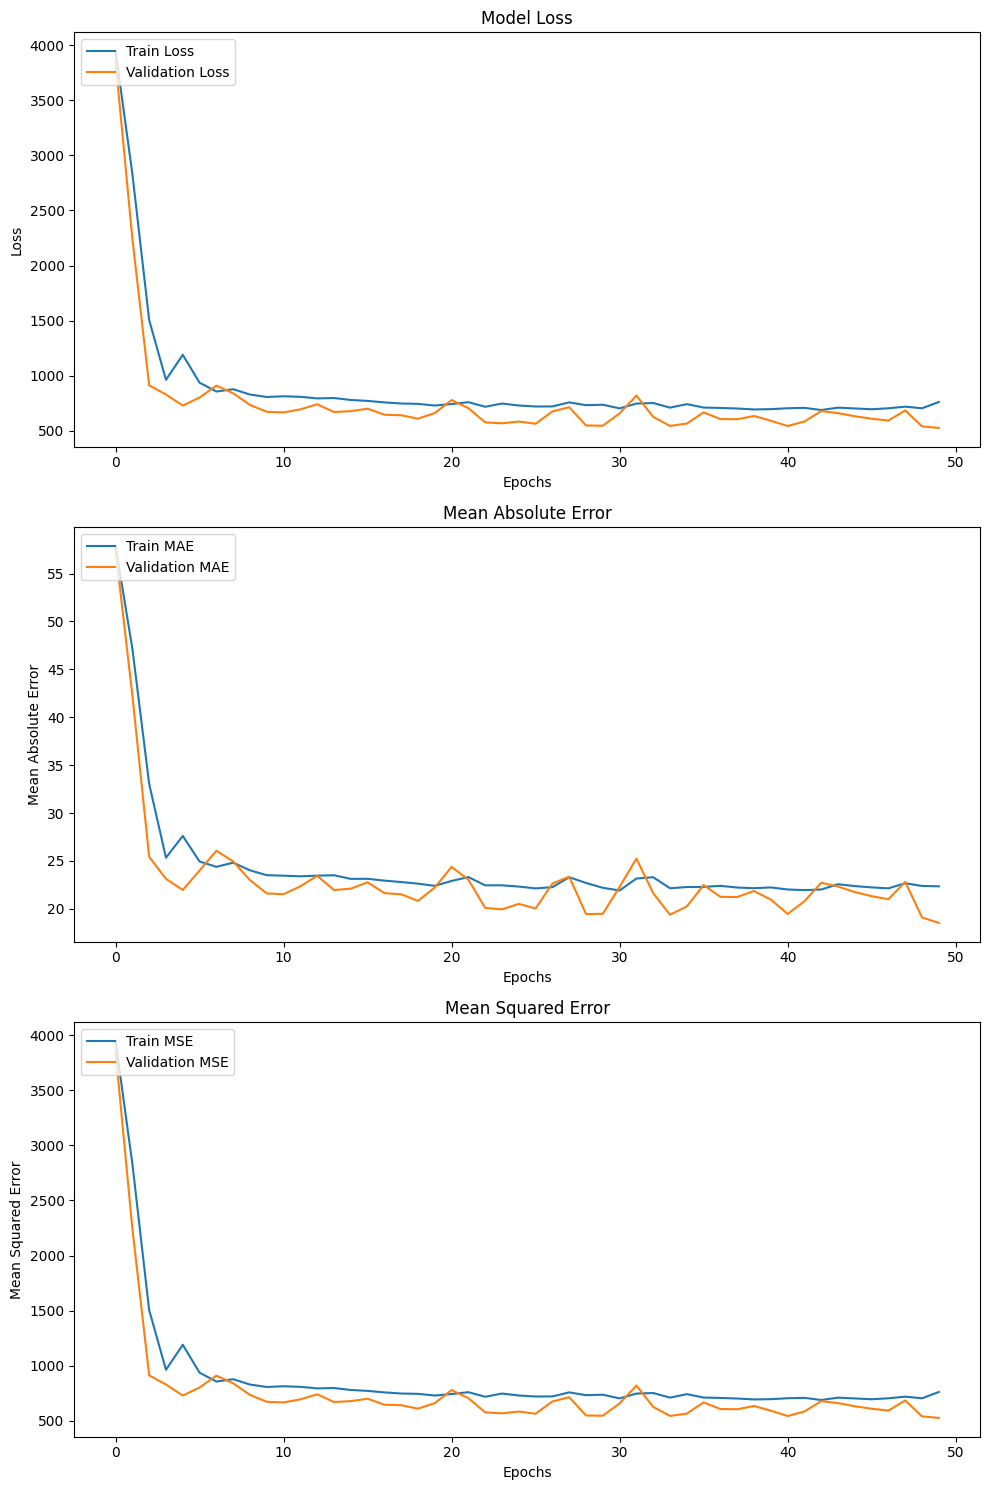

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot training and validation loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['mae'], label='Train MAE')
axs[1].plot(history.history['val_mae'], label='Validation MAE')
axs[1].set_title('Mean Absolute Error')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].legend(loc='upper left')

axs[2].plot(history.history['mse'], label='Train MSE')
axs[2].plot(history.history['val_mse'], label='Validation MSE')
axs[2].set_title('Mean Squared Error')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean Squared Error')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [31]:
y_pred = model.predict(X_test)
print(f'Shape of y_pred before flattening: {y_pred.shape}')
y_pred_reshaped = y_pred.mean(axis=(1, 2, 3)).flatten()

print(f'Shape of y_pred after reshaping: {y_pred_reshaped.shape} ypred ={np.argmax(y_pred_reshaped) }')

2/2 [==============================] - 1s 29ms/step
Shape of y_pred before flattening: (35, 7, 7, 1)
Shape of y_pred after reshaping: (35,) ypred =1


In [30]:
y_pred_reshaped

array([66.49968 , 66.50838 , 66.49307 , 66.4988  , 66.48796 , 66.49892 ,
       66.502235, 66.49627 , 66.492615, 66.48922 , 66.490776, 66.50404 ,
       66.49143 , 66.49037 , 66.49612 , 66.49912 , 66.49898 , 66.496254,
       66.4933  , 66.499504, 66.49663 , 66.50064 , 66.5043  , 66.49715 ,
       66.490944, 66.49449 , 66.49369 , 66.49129 , 66.496735, 66.49181 ,
       66.490845, 66.495155, 66.492096, 66.492775, 66.48827 ],
      dtype=float32)

In [29]:
y_pred.flatten().shape

(1715,)

In [17]:
fold_mae = []
fold_mse = []

In [18]:
mae = mean_absolute_error(y_test, y_pred_reshaped)
mse = mean_squared_error(y_test, y_pred_reshaped)
    
fold_mae.append(mae)
fold_mse.append(mse)
    
print(f'Fold MAE: {mae}, Fold MSE: {mse}')

Fold MAE: 21.40829877580915, Fold MSE: 706.9736317854625


In [19]:
avg_mae = np.mean(fold_mae)
avg_mse = np.mean(fold_mse)

print(f'Average MAE: {avg_mae}, Average MSE: {avg_mse}')

Average MAE: 21.40829877580915, Average MSE: 706.9736317854625


In [42]:
# model.save('final_model(integration).h5')

In [43]:
# model.save('final_model(integration).keras')

In [44]:
# tf.keras.models.load_model("final_model(integration).keras")